In [1]:
"""
Notebook: 03_test_invalid_states.ipynb
Objectif: Tester la génération d'états invalides
Auteur: [Ton nom]
Date: 2024-11-12
"""

import numpy as np
import matplotlib.pyplot as plt
import sys
from pathlib import Path

# Import du module
project_root = Path.cwd().parent
sys.path.insert(0, str(project_root / "src"))

from data_generation import (
    generate_valid_states,
    generate_invalid_states,
    verify_normalization,
    print_invalid_strategy_info
)

print("✅ Module importé avec succès!")

# Affiche les stratégies
print_invalid_strategy_info()

✅ Module importé avec succès!
STRATÉGIES DE GÉNÉRATION D'ÉTATS INVALIDES

📌 SCALING
   Multiplie des états valides par un facteur k ≠ 1. Contrôle: k ∈ [k_min, k_max] en évitant [0.95, 1.05]. Produit: ||ψ||² = k². Recommandé pour usage général.

📌 NOISE
   Ajoute du bruit à des états valides sans renormaliser. Paramètre noise_level contrôle l'intensité. Produit: états 'presque valides' (utile pour robustesse).

📌 DIRECT
   Génère directement des coefficients sans normalisation. Produit: large distribution de ||ψ||². Bonne diversité.

📌 MIXED
   Combine scaling, noise, direct + cas extrêmes. Paramètre extreme_prob contrôle % de outliers. Produit: dataset très diversifié. Recommandé pour dataset final.



In [2]:
print("=" * 70)
print("TEST 1 : STRATÉGIE SCALING")
print("=" * 70)

n_samples = 1000
dim = 4

states_invalid = generate_invalid_states(
    n_samples=n_samples,
    dim=dim,
    strategy="scaling",
    scale_range=(0.1, 2.0),
    seed=42
)

print(f"\n {n_samples} états invalides générés")
print(f" Shape: {states_invalid.shape}")

# Vérification (doit retourner False !)
all_valid, norms = verify_normalization(states_invalid)

print(f"\n Vérification:")
print(f"   Tous valides? {all_valid} (doit être False)")
print(f"   Min(||ψ||²) = {norms.min():.6f}")
print(f"   Max(||ψ||²) = {norms.max():.6f}")
print(f"   Moyenne(||ψ||²) = {norms.mean():.6f}")

# Compte combien sont accidentellement normalisés
accidentally_valid = np.isclose(norms, 1.0, atol=1e-4).sum()
print(f"   Nombre d'états accidentellement normalisés: {accidentally_valid}")
print(f"   → {accidentally_valid/n_samples*100:.2f}% (devrait être 0%)")

# Affiche quelques exemples
print(f"\n Exemples:")
for i in range(3):
    print(f"\nÉtat {i}: {states_invalid[i]}")
    print(f"  ||ψ||² = {norms[i]:.6f}")
    print(f"  Écart à 1.0: {abs(norms[i] - 1.0):.6f}")

TEST 1 : STRATÉGIE SCALING

 1000 états invalides générés
 Shape: (1000, 4)

 Vérification:
   Tous valides? False (doit être False)
   Min(||ψ||²) = 0.010474
   Max(||ψ||²) = 3.997804
   Moyenne(||ψ||²) = 1.416268
   Nombre d'états accidentellement normalisés: 0
   → 0.00% (devrait être 0%)

 Exemples:

État 0: [-0.46522603+0.4501232j   0.07592964-0.53597363j -0.08002791+0.31428442j
 -0.13476248-0.19155177j]
  ||ψ||² = 0.872111
  Écart à 1.0: 0.127889

État 1: [ 0.170132  +0.42319508j  0.93429903-1.07298896j -0.57581574-0.3966299j
  0.0328883 -0.52469502j]
  ||ψ||² = 2.997525
  Écart à 1.0: 1.997525

État 2: [ 0.50440936-0.33695247j -0.65361343-0.93318835j  0.1337643 +0.52300747j
 -0.11601306+0.24437136j]
  ||ψ||² = 2.030623
  Écart à 1.0: 1.030623


VISUALISATION : DISTRIBUTION DES NORMES²


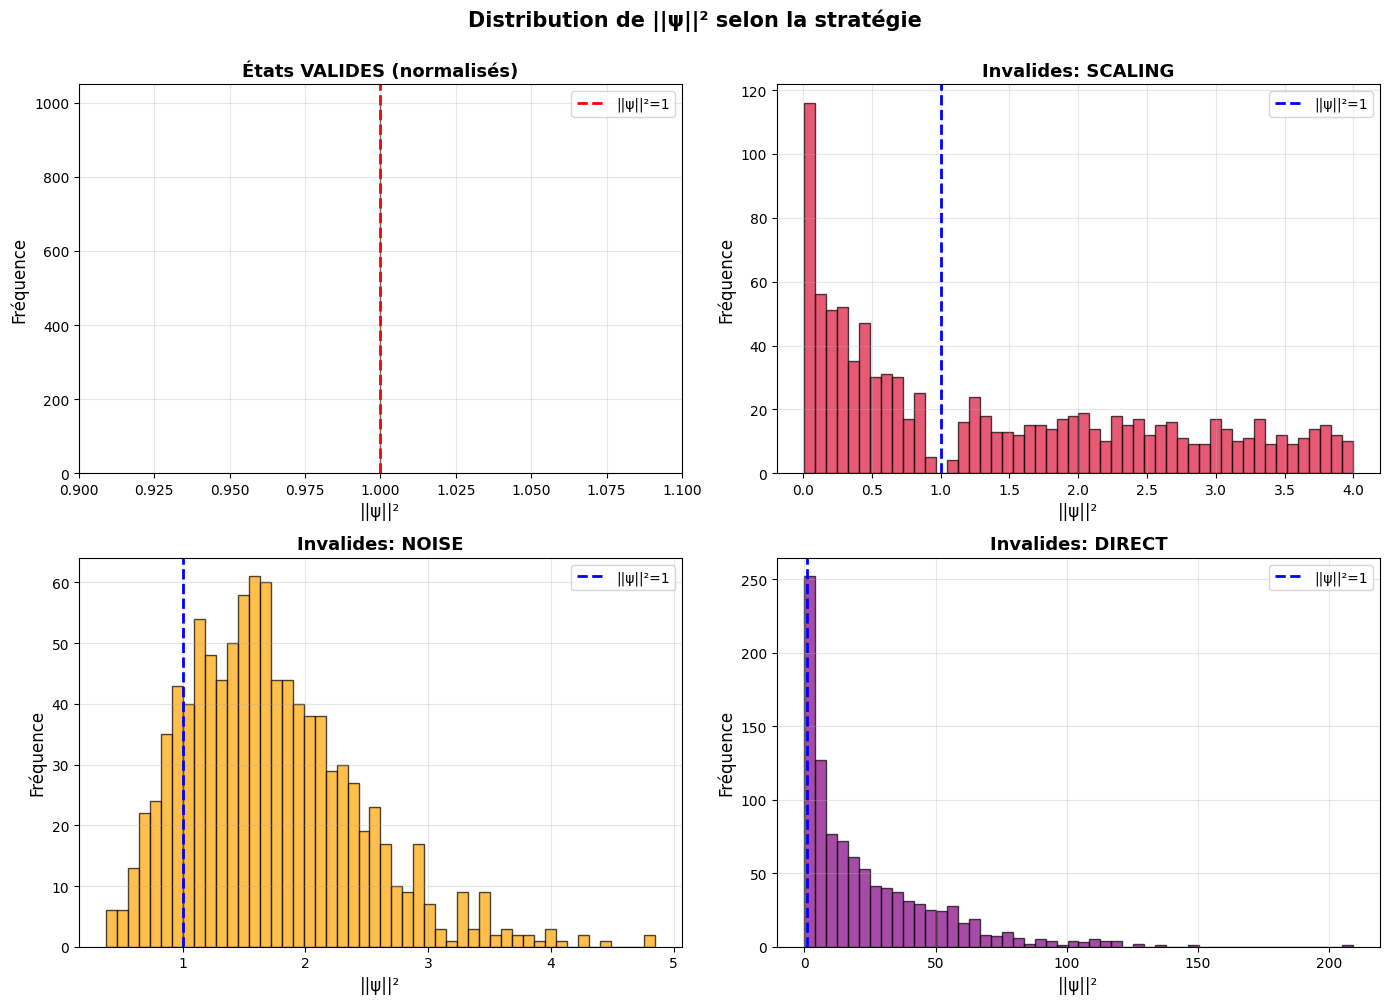


💡 Observations:
   - VALIDES: pic étroit à ||ψ||²=1 (tolérance numérique)
   - SCALING: distribution large, évite [0.95, 1.05]
   - NOISE: concentré près de 1 (états 'presque valides')
   - DIRECT: très large distribution


In [3]:
print("=" * 70)
print("VISUALISATION : DISTRIBUTION DES NORMES²")
print("=" * 70)

# Compare états valides vs invalides
states_valid = generate_valid_states(1000, dim=4, strategy="random", seed=10)
states_invalid_scaling = generate_invalid_states(1000, dim=4, strategy="scaling", seed=20)
states_invalid_noise = generate_invalid_states(1000, dim=4, strategy="noise", seed=30)
states_invalid_direct = generate_invalid_states(1000, dim=4, strategy="direct", seed=40)

# Calcule les normes
_, norms_valid = verify_normalization(states_valid)
_, norms_scaling = verify_normalization(states_invalid_scaling)
_, norms_noise = verify_normalization(states_invalid_noise)
_, norms_direct = verify_normalization(states_invalid_direct)

# helper pour tracer des histogrammes robustes lorsque la plage est nulle ou contient des non-finis
def safe_hist(ax, data, bins=50, color='gray', alpha=0.7, edgecolor='black'):
	arr = np.asarray(data)
	arr = arr[np.isfinite(arr)]
	if arr.size == 0:
		ax.text(0.5, 0.5, "No finite data", ha='center', va='center')
		return
	dmin, dmax = arr.min(), arr.max()
	if np.isclose(dmin, dmax):
		# si toutes les valeurs sont identiques, utiliser 1 bin et ajouter un petit padding pour l'affichage
		ax.hist(arr, bins=1, color=color, alpha=alpha, edgecolor=edgecolor)
		pad = max(0.1, 0.01 * abs(dmin)) if dmin != 0 else 0.1
		ax.set_xlim(dmin - pad, dmax + pad)
	else:
		ax.hist(arr, bins=bins, color=color, alpha=alpha, edgecolor=edgecolor)

# Histogrammes
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Valides
ax = axes[0, 0]
safe_hist(ax, norms_valid, bins=50, color='green', alpha=0.7, edgecolor='black')
ax.axvline(1.0, color='red', linestyle='--', linewidth=2, label='||ψ||²=1')
ax.set_xlabel('||ψ||²', fontsize=12)
ax.set_ylabel('Fréquence', fontsize=12)
ax.set_title('États VALIDES (normalisés)', fontsize=13, fontweight='bold')
ax.legend()
ax.grid(alpha=0.3)

# 2. Scaling
ax = axes[0, 1]
safe_hist(ax, norms_scaling, bins=50, color='crimson', alpha=0.7, edgecolor='black')
ax.axvline(1.0, color='blue', linestyle='--', linewidth=2, label='||ψ||²=1')
ax.set_xlabel('||ψ||²', fontsize=12)
ax.set_ylabel('Fréquence', fontsize=12)
ax.set_title('Invalides: SCALING', fontsize=13, fontweight='bold')
ax.legend()
ax.grid(alpha=0.3)

# 3. Noise
ax = axes[1, 0]
safe_hist(ax, norms_noise, bins=50, color='orange', alpha=0.7, edgecolor='black')
ax.axvline(1.0, color='blue', linestyle='--', linewidth=2, label='||ψ||²=1')
ax.set_xlabel('||ψ||²', fontsize=12)
ax.set_ylabel('Fréquence', fontsize=12)
ax.set_title('Invalides: NOISE', fontsize=13, fontweight='bold')
ax.legend()
ax.grid(alpha=0.3)

# 4. Direct
ax = axes[1, 1]
safe_hist(ax, norms_direct, bins=50, color='purple', alpha=0.7, edgecolor='black')
ax.axvline(1.0, color='blue', linestyle='--', linewidth=2, label='||ψ||²=1')
ax.set_xlabel('||ψ||²', fontsize=12)
ax.set_ylabel('Fréquence', fontsize=12)
ax.set_title('Invalides: DIRECT', fontsize=13, fontweight='bold')
ax.legend()
ax.grid(alpha=0.3)

plt.suptitle('Distribution de ||ψ||² selon la stratégie', fontsize=15, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

print("\n💡 Observations:")
print("   - VALIDES: pic étroit à ||ψ||²=1 (tolérance numérique)")
print("   - SCALING: distribution large, évite [0.95, 1.05]")
print("   - NOISE: concentré près de 1 (états 'presque valides')")
print("   - DIRECT: très large distribution")

TEST 2 : STRATÉGIE MIXED (avec cas extrêmes)
✅ 1000 états 'mixed' générés

📊 Statistiques des normes²:
   Min: 0.000157
   Max: 18358.927512
   Moyenne: 715.097747
   Médiane: 2.094444
   Écart-type: 2904.062845

🔍 Cas extrêmes détectés:
   ||ψ||² < 0.01: 47 (4.7%)
   ||ψ||² > 10: 282 (28.2%)
   Total extrêmes: 329 (≈15% attendu)


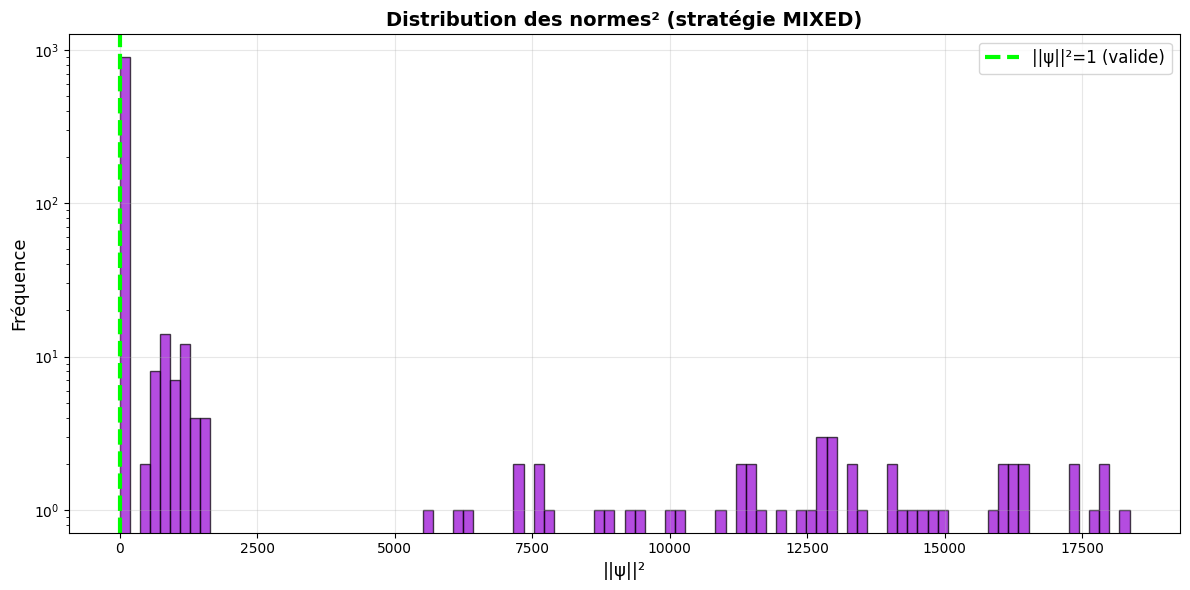


💡 Cette stratégie 'mixed' est idéale pour le dataset final:
   - Diversité maximale
   - Inclut des outliers (cas extrêmes)
   - Teste la robustesse du modèle ML


In [5]:
print("=" * 70)
print("TEST 2 : STRATÉGIE MIXED (avec cas extrêmes)")
print("=" * 70)

states_mixed = generate_invalid_states(
    n_samples=1000,
    dim=4,
    strategy="mixed",
    extreme_prob=0.15,  # 15% de cas extrêmes
    seed=42
)

_, norms_mixed = verify_normalization(states_mixed)

print(f"✅ 1000 états 'mixed' générés\n")

# Statistiques
print(f"📊 Statistiques des normes²:")
print(f"   Min: {norms_mixed.min():.6f}")
print(f"   Max: {norms_mixed.max():.6f}")
print(f"   Moyenne: {norms_mixed.mean():.6f}")
print(f"   Médiane: {np.median(norms_mixed):.6f}")
print(f"   Écart-type: {norms_mixed.std():.6f}")

# Identifie les cas extrêmes
extremely_small = (norms_mixed < 0.01).sum()
extremely_large = (norms_mixed > 10).sum()

print(f"\n🔍 Cas extrêmes détectés:")
print(f"   ||ψ||² < 0.01: {extremely_small} ({extremely_small/10:.1f}%)")
print(f"   ||ψ||² > 10: {extremely_large} ({extremely_large/10:.1f}%)")
print(f"   Total extrêmes: {extremely_small + extremely_large} (≈15% attendu)")

# Visualisation
fig, ax = plt.subplots(figsize=(12, 6))

# Histogramme avec échelle log pour mieux voir les extrêmes
ax.hist(norms_mixed, bins=100, color='darkviolet', alpha=0.7, edgecolor='black')
ax.axvline(1.0, color='lime', linestyle='--', linewidth=3, label='||ψ||²=1 (valide)')
ax.set_xlabel('||ψ||²', fontsize=13)
ax.set_ylabel('Fréquence', fontsize=13)
ax.set_title('Distribution des normes² (stratégie MIXED)', fontsize=14, fontweight='bold')
ax.set_yscale('log')  # Échelle log pour voir les queues
ax.legend(fontsize=12)
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\n💡 Cette stratégie 'mixed' est idéale pour le dataset final:")
print("   - Diversité maximale")
print("   - Inclut des outliers (cas extrêmes)")
print("   - Teste la robustesse du modèle ML")

COMPARAISON VALIDES VS INVALIDES


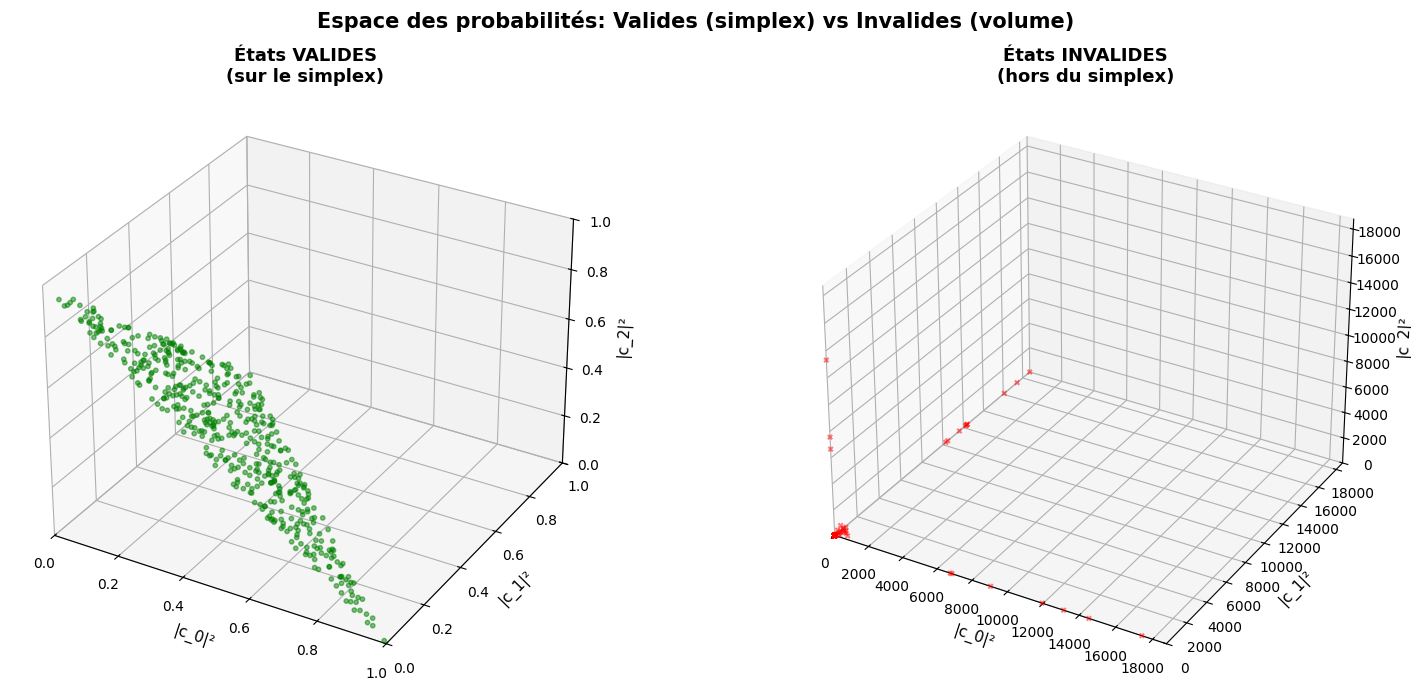


💡 Observation FONDAMENTALE:
   - États VALIDES: confinés sur une surface 2D (le simplex)
     Car: |c_0|² + |c_1|² + |c_2|² = 1 (contrainte)

   - États INVALIDES: remplissent un volume 3D
     Car: |c_0|² + |c_1|² + |c_2|² ≠ 1 (pas de contrainte)

   Le ML doit apprendre cette distinction géométrique!


In [6]:
print("=" * 70)
print("COMPARAISON VALIDES VS INVALIDES")
print("=" * 70)

# Génère les deux types
n = 500
states_v = generate_valid_states(n, dim=3, strategy="random", seed=1)
states_inv = generate_invalid_states(n, dim=3, strategy="mixed", seed=2)

# Calcule probabilités
probs_v = np.abs(states_v)**2
probs_inv = np.abs(states_inv)**2

# Plot 3D
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(16, 7))

# Subplot 1 : Valides
ax1 = fig.add_subplot(121, projection='3d')
ax1.scatter(probs_v[:, 0], probs_v[:, 1], probs_v[:, 2],
            c='green', marker='o', s=10, alpha=0.5, label='Valides')
ax1.set_xlabel('|c_0|²', fontsize=11)
ax1.set_ylabel('|c_1|²', fontsize=11)
ax1.set_zlabel('|c_2|²', fontsize=11)
ax1.set_title('États VALIDES\n(sur le simplex)', fontsize=13, fontweight='bold')
ax1.set_xlim(0, 1)
ax1.set_ylim(0, 1)
ax1.set_zlim(0, 1)

# Subplot 2 : Invalides
ax2 = fig.add_subplot(122, projection='3d')
ax2.scatter(probs_inv[:, 0], probs_inv[:, 1], probs_inv[:, 2],
            c='red', marker='x', s=10, alpha=0.5, label='Invalides')
ax2.set_xlabel('|c_0|²', fontsize=11)
ax2.set_ylabel('|c_1|²', fontsize=11)
ax2.set_zlabel('|c_2|²', fontsize=11)
ax2.set_title('États INVALIDES\n(hors du simplex)', fontsize=13, fontweight='bold')

# Ajuste les limites pour voir les outliers
max_coord = max(probs_inv.max(), 2.0)
ax2.set_xlim(0, max_coord)
ax2.set_ylim(0, max_coord)
ax2.set_zlim(0, max_coord)

plt.suptitle('Espace des probabilités: Valides (simplex) vs Invalides (volume)', 
             fontsize=15, fontweight='bold')
plt.tight_layout()
plt.show()

print("\n💡 Observation FONDAMENTALE:")
print("   - États VALIDES: confinés sur une surface 2D (le simplex)")
print("     Car: |c_0|² + |c_1|² + |c_2|² = 1 (contrainte)")
print("")
print("   - États INVALIDES: remplissent un volume 3D")
print("     Car: |c_0|² + |c_1|² + |c_2|² ≠ 1 (pas de contrainte)")
print("")
print("   Le ML doit apprendre cette distinction géométrique!")